#### <h1><center>CMSC 478: Introduction to Machine Learning</center></h1>

<center><img src="img/title.jpg" align="center"/></center>


<h3 style="color:blue;"><center>Instructor: Fereydoon Vafaei</center></h3>


<h5 style="color:purple;"><center>Ensemble Methods and Random Forests</center></h5>

<center><img src="img/UMBC_logo.png" align="center"/></center>

<h1><center>Agenda</center></h1>

- <b> Ensemble Methods:</b>
    - Hard Voting vs Soft Voting
    - Bootstrap Aggregating (Bagging) & Pasting
        - Random Forests
    - Boosting
        - AdaBoost
        - Gradient Boosting
        - XGBoost
    - Stacking

<h1><center>Ensemble Methods</center></h1>
<h3><center>The Wisdom of the Crowd</center></h3>

- If you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor.

- A group of predictors is called an ensemble; thus, this technique is called **Ensemble Learning**, and an Ensemble Learning algorithm is called an **Ensemble method**.

- As an example of an Ensemble method, you can train a group of Decision Tree classifiers, each on a different random subset of the training set. To make predictions, you obtain the predictions of all the individual trees, then predict the class that gets the most votes.

- Such an ensemble of Decision Trees is called a **Random Forest**, and despite its simplicity, this is one of the most powerful Machine Learning algorithms available today.

<h1><center>Voting Classifiers</center></h1>

- Suppose you have trained a few classifiers, each one achieving about 80% accuracy. You may have a Logistic Regression classifier, an SVM classifier, a Random Forest classifier, a K-Nearest Neighbors classifier, and perhaps a few more (see Figure 7-1).

<center><img src="img/ensemble.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Hard Voting</center></h1>

- A very simple way to create an even better classifier is to **aggregate** the predictions of each classifier and predict the class that gets the most votes (see Figure 7-2).

- This majority-vote classifier is called a **hard voting** classifier.

- This voting classifier often achieves a higher accuracy than the best classifier in the ensemble. In fact, even if each classifier is a weak learner (meaning it does only slightly better than random guessing), the ensemble can still be a strong learner (achieving high accuracy), provided there are a sufficient number of weak learners and they are sufficiently diverse.

<center><img src="img/hard-voting.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>The Law of Large Numbers</center></h1>

- The following analogy can help shed some light on this mystery:
    - Suppose you have a slightly biased coin that has a 51% chance of coming up heads and 49% chance of coming up tails. If you toss it 1,000 times, you will generally get more or less 510 heads and 490 tails, and hence a majority of heads.

- If you do the math, you will find that the probability of obtaining a majority of heads after 1,000 tosses is close to 75%. The more you toss the coin, the higher the probability (e.g., with 10,000 tosses, the probability climbs over 97%). This is due to the law of large numbers: as you keep tossing the coin, the ratio of heads gets closer and closer to the probability of heads (51%).

<center><img src="img/coin-tosses.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Simulation of The Law of Large Numbers</center></h1>

- The following plot shows 10 series of biased coin tosses.

- You can see that as the number of tosses increases, the ratio of heads approaches 51%. Eventually all 10 series end up so close to 51% that they are consistently above 50%.

In [1]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

(0.0, 10000.0, 0.42, 0.58)

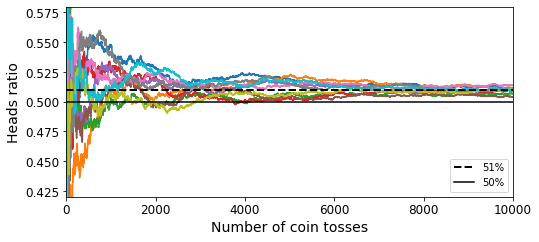

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])

<h1><center>Ensemble of Weak Learners - Soft vs Hard Voting</center></h1>

- Ensemble methods work best when the predictors are **independent** from one another making **uncorrelated** errors.

- One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy.

- <font color="blue"><b>Soft Voting:</b></font> If all classifiers can estimate class probabilities (i.e., they all have a `predict_proba()` method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called **soft voting**.

- <font color="blue"><b>Soft Voting</b></font> often achieves higher performance than hard voting because it gives more weight to highly confident votes.

- All you need to do is replace `voting="hard"` with `voting="soft"` and ensure that all classifiers can estimate class probabilities.

<h1><center>Hard Voting in Scikit-Learn</center></h1>

- The following code creates and trains a voting classifier in Scikit-Learn, composed of three diverse classifiers ---the training set is the moons dataset (binary classification):

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train[:5]

array([[ 1.53869929,  0.18874413],
       [ 0.39469854,  0.32372361],
       [-0.91914656,  1.31188165],
       [ 1.05396355, -0.70040787],
       [ 1.04067847, -0.4373387 ]])

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

# Notice the voting='hard'
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rf_clf), ('svc', svm_clf)],
    voting='hard')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [11]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rf_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


- There you have it! The voting classifier slightly outperforms all the individual classifiers.

<h1><center>Soft Voting in Scikit-Learn</center></h1>

- The following code uses **soft voting** which slightly improves the result:

In [12]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

# Notice the voting='soft'
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rf_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [13]:
for clf in (log_clf, rf_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


<h1><center>Bootstrap Aggregating (Bagging) and Pasting</center></h1>

- One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed. 
- Another approach is to use the same training algorithm for every predictor and train them on different random subsets of the training set.
- When sampling is performed with replacement, this method is called **bagging** (short for bootstrap aggregating).
- When sampling is performed without replacement, it is called **pasting**.
- Both **bagging** and **pasting** allow training instances to be sampled several times across multiple predictors, but only **bagging** allows training instances to be sampled several times for the same predictor.

<center><img src="img/bagging.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Bagging & Pasting - Bias-Variance Tradeoff</center></h1>

- The aggregation function is typically the **statistical mode** (i.e., the most frequent prediction, just like a hard voting classifier) for classification, or the average for regression.


- Each individual predictor has a higher **bias** than if it were trained on the original training set, but aggregation generally reduces both **bias** and **variance** or at least one of them.


- Generally, the net result is that the ensemble has a similar (or slightly higher) **bias** but a lower **variance** than a single predictor trained on the original training set.

<h1><center>Bagging & Pasting - Parallel Processing</center></h1>

- Individual predictors can all be trained in parallel, via different CPU cores or even different servers.


- Similarly, predictions can be made in parallel. This is one of the reasons bagging and pasting are such popular methods: <font color="blue">ensemble methods scale very well!</font>


- Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher **bias** than pasting; but the extra diversity also means that the predictors end up being less correlated, so the ensemble’s **variance** is reduced.


- Overall, **bagging** often results in better models.

<h1><center>Bagging & Pasting in Scikit-Learn</center></h1>

- Scikit-Learn offers a simple API for both bagging and pasting with the `BaggingClassifier` class (or `BaggingRegressor` for regression).

- The following code trains an ensemble of 500 Decision Tree classifiers: 5 each is trained on 100 training instances randomly sampled from the training set with replacement (this is an example of bagging, but if you want to use pasting instead, just set `bootstrap=False`).

- The `n_jobs` parameter tells Scikit-Learn the number of CPU cores to use for training and predictions (–1 tells Scikit-Learn to use all available cores):

In [16]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [18]:
# Notice the decline in accuracy by using an individual decision tree:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


<h1><center>Single Decision Tree vs Ensemble</center></h1>

- The following plot compares the decision boundary of a single Decision Tree with the decision boundary of a bagging ensemble of 500 trees (from the preceding code), both trained on the moons dataset.

- As you can see, the ensemble’s predictions will likely generalize much better than the single Decision Tree’s predictions: the ensemble has a comparable bias but a smaller variance (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular).

In [19]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Text(0, 0.5, '')

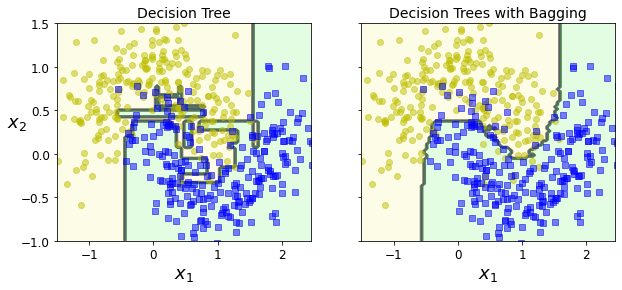

In [20]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")

<h1><center>Out Of Bag Evaluation: oob</center></h1>

- With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all.


- By default a `BaggingClassifier` samples **m** training instances with replacement ( `bootstrap=True` ), where **m** is the size of the training set.


- This means that only about 63% of the training instances are sampled on average for each predictor. The remaining 37% of the training instances that are not sampled are called <font color="blue">out-of-bag (oob)</font> instances. Note that they are not the same 37% for all predictors.


- As **m** grows, this ratio approaches `1 – exp(–1) ≈ 63.212%`. $1 - e^{-1} ≈ 63\% $

<h1><center>How to Calculate oob Ratio</center></h1>

<center><img src="img/oob-prob.png" align="center"/></center>

<font size='1'>Slide from Ref[2]</font>

<h1><center>oob As Validation Set</center></h1>

- Since a predictor never sees the **oob** instances during training, it can be evaluated on these instances, without the need for a separate validation set.


- You can evaluate the ensemble itself by averaging out the **oob** evaluations of each predictor.

<h1><center>Random Patches and Random Subspaces</center></h1>

- Sampling both training instances and features is called the <font color="blue">Random Patches</font> method.


- Keeping all training instances (by setting `bootstrap=False` and `max_samples=1.0` ) but sampling features (by setting `bootstrap_features` to True and/or `max_features` to a value smaller than 1.0 ) is called the <font color="blue">Random Subspaces</font> method.


- Sampling features results in even more predictor diversity, trading a bit more **bias** for a lower **variance**.

<h1><center>Random Forests</center></h1>

- <font color="blue">Random Forest</font> is an **ensemble** of **Decision Trees**, generally trained via the **bagging** method.


- The <font color="blue">Random Forest</font> algorithm introduces extra **randomness** when growing trees:

    - Instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features.


- The algorithm results in greater tree diversity, which trades a higher **bias** for a lower **variance**, generally yielding an overall better model.

<h1><center>Random Forests in Scikit-Learn</center></h1>

- As we have discussed, a Random Forest is an ensemble of Decision Trees, generally trained via the bagging method (or sometimes pasting), typically with `max_samples` set to the size of the training set.

- Instead of building a `BaggingClassifier` and passing it a `DecisionTreeClassifier`, you can instead use the `RandomForestClassifier` class, which is more convenient and optimized for Decision Trees (similarly, there is a `RandomForestRegressor` class for regression tasks).

- The following code uses all available CPU cores to train a Random Forest classifier with 500 trees (each limited to maximum 16 nodes):

In [21]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [22]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.976

<h1><center>Extremely Randomized Trees</center></h1>

- When you are growing a tree in a Random Forest, at each node only a random subset of the features is considered for splitting.


- It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds (like regular Decision Trees do).


- A forest of such extremely random trees is called an <font color="blue">Extremely Randomized Trees </font> ensemble (or **Extra-Trees** for short).


- Once again, this technique trades more **bias** for a lower **variance**.


- It also makes **Extra-Trees** much faster to train than regular Random Forests, because finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree.

<h1><center>Feature Importance</center></h1>

- Another great quality of **Random Forests** is that they make it easy to measure the relative importance of each feature.


- Scikit-Learn measures a **feature’s importance** by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest).


- More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it.

<h1><center>Feature Importance for MNIST</center></h1>

- If you train a Random Forest classifier on the MNIST dataset and plot each pixel’s importance, you get the image represented in Figure 7-6.

<center><img src="img/feature-importance.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Feature Importance for MNIST</center></h1>

- The following code generates the plot of feature importance.

In [25]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(mnist["data"], mnist["target"])

[Text(1, 0.0, 'Not important'),
 Text(1, 0.009791489757332336, 'Very important')]

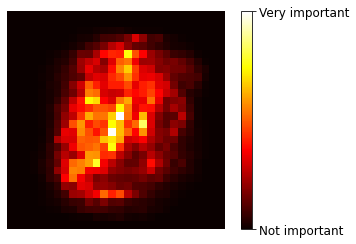

In [29]:
plot_digit(rf_clf.feature_importances_)

# Notice how you access feature importance directly from rf_clf.feature_importances_
cbar = plt.colorbar(ticks=[rf_clf.feature_importances_.min(), rf_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

<h1><center>Boosting</center></h1>

- <font color="blue">Boosting</font> (originally called hypothesis boosting) refers to any **Ensemble** method that can combine several **weak learners** into a strong learner.


- The general idea of most <font color="blue">Boosting</font> methods is to train predictors **sequentially**, each trying to correct its predecessor.


- There are many <font color="blue">Boosting</font> methods available, but by far the most popular are <font color="blue">AdaBoost</font> (short for Adaptive Boosting) and <font color="blue">Gradient Boosting</font> (and its variations like <font color="blue">XGBoost</font>).

<h1><center>AdaBoost</center></h1>

- One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. This results in new predictors focusing more and more on the hard cases. This is the technique used by **AdaBoost**.

- For example, when training an **AdaBoost** classifier, the algorithm first trains a base classifier (such as a Decision Tree) and uses it to make predictions on the training set.

- The algorithm then increases the relative weight of misclassified training instances.

- Then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updates the instance weights, and so on.

<center><img src="img/adaboost.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>AdaBoost</center></h1>

- Figure 7-8 shows the decision boundaries of five consecutive predictors on the moons dataset.

- The first classifier gets many instances wrong, so their weights get boosted.

- The second classifier therefore does a better job on these instances, and so on.

- The plot on the right represents the same sequence of predictors, except that the learning rate is halved (i.e., the misclassified instance weights are boosted half as much at every iteration).

- As you can see, this sequential learning technique has some similarities with Gradient Descent, except that instead of tweaking a single predictor’s parameters to minimize a cost function, **AdaBoost** adds predictors to the ensemble, gradually making it better.

<center><img src="img/fig-7-8.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>AdaBoost Predictions</center></h1>

- Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set.


- There is one important drawback to this sequential learning technique: it cannot be parallelized (or only partially), since each predictor can only be trained after the previous predictor has been trained and evaluated.


- As a result, **AdaBoost** does not scale as well as bagging or pasting.

<h1><center>AdaBoost Math</center></h1>

- Each instance weight $w^{(i)}$ is initially set to $1/m$ where $m$ is the total number of instances

- A first predictor is trained, and its weighted error rate $r_1$ is computed on the training set.

**Equation 7-1: Weighted error rate $r_j$ of the $j^\text{th}$ predictor**

$
r_j = \dfrac{\displaystyle \sum\limits_{\textstyle {i=1 \atop \hat{y}_j^{(i)} \ne y^{(i)}}}^{m}{w^{(i)}}}{\displaystyle \sum\limits_{i=1}^{m}{w^{(i)}}} \quad
\text{where }\hat{y}_j^{(i)}\text{ is the }j^{\text{th}}\text{ predictor's prediction for the }i^{\text{th}}\text{ instance.}
$

<h1><center>AdaBoost Math Cont.</center></h1>

- The predictor’s weight $α_j$ is then computed using Equation 7-2, where $\eta$ is the learning rate hyperparameter (defaults to 1).

- The more accurate the predictor is, the higher its weight will be.

- If it is just guessing randomly, then its weight will be close to zero.

- However, if it is most often wrong (i.e., less accurate than random guessing), then its weight will be negative.

**Equation 7-2: Predictor weight**

$
\begin{split}
\alpha_j = \eta \log{\dfrac{1 - r_j}{r_j}}
\end{split}
$


<h1><center>AdaBoost Math Cont.</center></h1>

- Next, the AdaBoost algorithm updates the instance weights, using Equation 7-3, which boosts the weights of the misclassified instances.

**Equation 7-3: Weight update rule**

$
\begin{split}
& \text{ for } i = 1, 2, \dots, m \\
& w^{(i)} \leftarrow
\begin{cases}
w^{(i)} & \text{if }\hat{y_j}^{(i)} = y^{(i)}\\
w^{(i)} \exp(\alpha_j) & \text{if }\hat{y_j}^{(i)} \ne y^{(i)}
\end{cases}
\end{split}
$

- Then all the instance weights are normalized (i.e., divided by $ \sum_{i=1}^{m}{w^{(i)}} $).

<h1><center>AdaBoost Prediction Math</center></h1>

- Finally, a new predictor is trained using the updated weights, and the whole process is repeated (the new predictor’s weight is computed, the instance weights are updated, then another predictor is trained, and so on). The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found.


- To make predictions, AdaBoost simply computes the predictions of all the predictors and weighs them using the predictor weights $\alpha_j$. The predicted class is the one that receives the majority of weighted votes.

**Equation 7-4: AdaBoost predictions**

$
\hat{y}(\mathbf{x}) = \underset{k}{\operatorname{argmax}}{\sum\limits_{\scriptstyle j=1 \atop \scriptstyle \hat{y}_j(\mathbf{x}) = k}^{N}{\alpha_j}} \quad \text{where }N\text{ is the number of predictors.}
$


<h1><center>AdaBoostClassifier in Scikit-Learn</center></h1>

- The following code builds an `AdaBoostClassifier`:

In [30]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

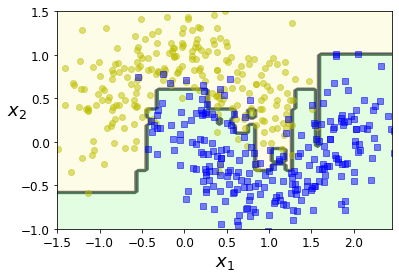

In [31]:
plot_decision_boundary(ada_clf, X, y)

<h1><center>Gradient Boosting</center></h1>

- Just like **AdaBoost**, <font color="blue">Gradient Boosting</font> works by sequentially adding predictors to an ensemble, each one correcting its predecessor.

- However, instead of tweaking the instance weights at every iteration like AdaBoost does, <font color="blue">Gradient Boosting</font> tries to fit the new predictor to the **residual errors** made by the previous predictor.

<h1><center>Gradient Boosting</center></h1>

- Let’s go through a simple regression example, using Decision Trees as the base predictors (of course, Gradient Boosting also works great with regression tasks). This is called Gradient Tree Boosting, or Gradient Boosted Regression Trees (**GBRT**).

- First, let’s fit a `DecisionTreeRegressor` to the training set (for example, a noisy quadratic training set):

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

- Next, we’ll train a second `DecisionTreeRegressor` on the residual errors made by the
first predictor:

In [ ]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

<h1><center>Gradient Boosting Cont.</center></h1>

- Then we train a third regressor on the residual errors made by the second predictor:

In [ ]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

- Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [ ]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

<h1><center>Gradient Boosting - Training on Residual Errors</center></h1>

- Figure 7-9 represents the predictions of three trees in the left column, and the ensemble’s predictions in the right column.

- In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

<center><img src="img/fig-7-9.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Regularization in GBRT - Shrinkage</center></h1>

- The `learning_rate` hyperparameter scales the contribution of each tree. If you set it to a low value, such as 0.1 , you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better.

- This is a regularization technique called **shrinkage**.

- Figure 7-10 shows two GBRT ensembles trained with a low learning rate: the one on the left does not have enough trees to fit the training set, while the one on the right has too many trees and overfits the training set.

<center><img src="img/fig-7-10.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Early Stopping</center></h1>

- In order to find the optimal number of trees, you can use **early stopping**.

- It is possible to implement **early stopping** by actually stopping training early (instead of training a large number of trees first and then looking back to find the optimal number).

<center><img src="img/fig-7-11.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>XGBoost - Extreme Gradient Boosting</center></h1>

- An optimized implementation of **Gradient Boosting** is available in the popular Python library <font color="blue">[XGBoost](https://xgboost.readthedocs.io/en/latest/)</font>, which stands for **Extreme Gradient Boosting**.


- This package was initially developed by [Tianqi Chen](https://arxiv.org/pdf/1603.02754.pdf) as part of the Distributed (Deep) Machine Learning Community (DMLC), and it aims to be extremely fast, scalable, and portable.


- In fact, <font color="blue">[XGBoost](http://dmlc.cs.washington.edu/xgboost.html)</font> is often an important component of the winning entries in ML competitions.

<h1><center>Stacking</center></h1>

- <font color="blue">Stacking</font> (short for stacked generalization) is based on a simple idea: instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, why don’t we train a model to learn this aggregation?

- Figure 7-12 shows such an ensemble performing a regression task on a new instance. Each of the bottom three predictors predicts a different value (3.1, 2.7, and 2.9), and then the final predictor (called a **blender**, or a meta learner) takes these predictions as inputs and makes the final prediction (3.0).

<center><img src="img/stacking-1.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Stacking Cont.</center></h1>

- To train the blender, a common approach is to use a <font color="blue"><b>hold-out set</b></font> (Subset 2).

- First, the training set is split into two subsets. The first subset is used to train the predictors in the first layer.

<center><img src="img/stacking-2.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Stacking Cont.</center></h1>

- Next, the first layer’s predictors are used to make predictions on the second (held-out) set.

- This ensures that the predictions are “clean,” since the predictors never saw these instances during training. For each instance in the hold-out set, there are three predicted values.

- We can create a new training set using these predicted values as input features (which makes this new training set 3D), and keeping the target values. The blender is trained on this new training set, so it learns to predict the target value, given the first layer’s predictions.

<center><img src="img/stacking-3.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Stacking Cont.</center></h1>

- It is actually possible to train several different blenders this way (e.g., one using Linear Regression, another using Random Forest Regression), to get a whole layer of blenders.

- The trick is to split the training set into three subsets: the first one is used to train the first layer, the second one is used to create the training set used to train the second layer (using predictions made by the predictors of the first layer), and the third one is used to create the training set to train the third layer (using predictions made by the predictors of the second layer).

- Once this is done, we can make a prediction for a new instance by going through each layer sequentially.

<center><img src="img/stacking-4.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Next Topic - Dimensionality Reduction & PCA</center></h1>

<h1><center>References</center></h1>

[1] Hands-On ML Textbook Edition-2 2019

[2] [David Rosenberg's Slides - NYU](https://davidrosenberg.github.io/mlcourse/Archive/2017/Lectures/9a.bagging-random-forests.pdf) 